# Linear Downscaling for Precipitation

#### Katrina Wheelan, updated 7.21.20

Updates 7/21:

 * Added distribution plots of the predictors and the observed predictand.
 * Added a 4th root transformation for the obs (and a transformation back for the final predictions)
 * Added a stochastic threshold for the conditional regression
 

This notebook uses various atmospheric predictors to predict the probabilty of precipitation (linearly or logistically) and then another linear model to predict the intensity of precipitation. There is an option to add a stochastic component to the linear model.

Steps: 

- Import data
- standardize
- Logistic regression to predict probability
- LASSO or manual selection linear regression using large scale predictors to predict intensity
- stochastic piece --- Gaussian or Gamma distribution
- save predictionss

### Importing the necessary packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import os

## Input Coordinates

In [2]:
#Adjust these if needed; takes a single cell
lat = 36.608
lon = -97.488

## Prepping the Data for analysis

Run the code below or skip to the cell with the stars if you want to use pre-prepped data for (36.608, -97.488)

### Importing the predictors

In [3]:
ROOT = '/glade/p/cisl/risc/rmccrary/ERA-I/NAmerica/' #where the files are saved
EXT = '_19790101-20061231_dayavg.nc' #date range at the end of the file
SERIES = 'ERAI_NAmerica'

#The variables to use
surface_predictors = ['mslp', 'uas', 'vas', 'ps']
#Each of these predictors is taken at each pressure level below
other_predictors = ['Q', 'RH', 'U', 'V', 'Z', 'Vort', 'Div']
levels = [500, 700, 850] #pressure levels

#Surface predictors
for var in surface_predictors:
    file = ROOT + var + '_' + SERIES + '_surf' + EXT
    if var == 'mslp': predictors = xr.open_dataset(file)[var]
    predictors = xr.merge([predictors, xr.open_dataset(file)[var]])

#Other predictors (at multiple pressure levels)
for var in other_predictors:
    for level in levels:
        file = ROOT + var + '_' + SERIES + '_p' + str(level) + EXT
        predictors = xr.merge([predictors, xr.open_dataset(file).rename({var: var + '_p' + str(level)})])

### Standardizing the input variables

In [4]:
#convert to pandas dataframe in order to use scikit-learn later

def standardize(variable):
    """Standardizing a variable (converting to z-scores)
    Takes as input an Xarray dataset; outputs a standardized Xarray object"""
    return (variable - np.mean(variable)) / np.std(variable)

for col in [i for i in predictors.keys()]:
    #standardize each predictor
    predictors[col] = standardize(predictors[col])

### Get observations and training data

In [5]:
#import observations
obs = xr.open_mfdataset("/glade/p/ral/hap/common_data/Maurer_met_full/pr" + 
                "/nldas_met_update.obs.daily.pr.****.nc").sel(time = slice('1979-01-01','2006-12-31'))

#getting training data 
X_all = predictors.sel(lat = lat, lon = lon, method = 'nearest')
Y_all = obs.sel(latitude = lat, longitude = lon, method = 'nearest')

### Plot observed data distributions

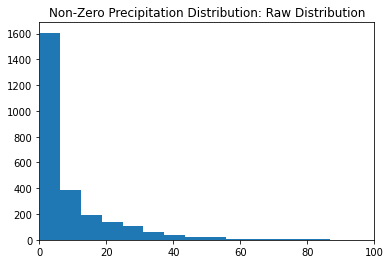

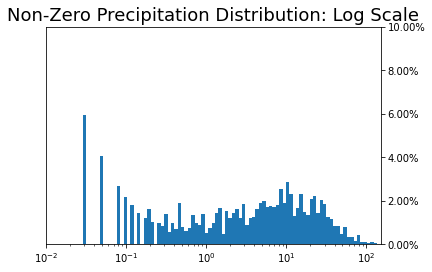

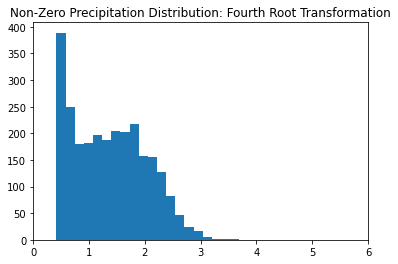

In [6]:
data = Y_all.pr

prednon0=data[data > 0.00] #filtering to get only non-zero precip values

plt.hist(prednon0, bins = 30)
plt.xlim(0,100)
plt.title("Non-Zero Precipitation Distribution: Raw Distribution")
plt.show()

length = prednon0.shape[0] #number of pts

#getting it on a log scale
ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
logbins = np.geomspace(0.01,150, 100) #args are x-min, x-max, number of bins

#plot details
plt.hist(prednon0,bins=logbins, weights=np.ones(length) / length) #plot percentages
plt.title('Non-Zero Precipitation Distribution: Log Scale',fontsize=18) #title
plt.xlim(xmin=0.01, xmax = 150)
plt.ylim(ymin=0, ymax = 0.1)

#add % to axis labels
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax.yaxis.tick_right()
plt.show()

plt.hist((prednon0**.25), bins=20)
plt.xlim(0,6)
plt.title("Non-Zero Precipitation Distribution: Fourth Root Transformation")
plt.show()



### Add a 4th root transformation to obs data

In [7]:
Y_all['pr'] = Y_all.pr**(.25)

### Add a column of ones for constants

In [8]:
#adding a column of ones for a constant (since the obs aren't standardized they aren't centered around zero)
all_preds = [key for key in X_all.keys()] #the names of the predictors
X_all['constant'] = 1 + 0*X_all[all_preds[0]] #added the last part so it's dependent on lat, lon, and time
if not 'constant' in all_preds: all_preds += ['constant'] #adding "constant" to the list of variable names

### Separate Training and Testing Data

Right now I have even years for training and odd years for testing

In [ ]:
def evenOdd(ds):
    """Input: xarray dataset
        Output: even and odd year datasets as xarray objects"""
    ds['time-copy'] = ds['time']
    #classify years as even or odd
    ds['time'] =  pd.DatetimeIndex(ds.time.values).year%2 == 0
    even, odd = ds.sel(time = True), ds.sel(time = False)
    even['time'], odd['time'] = even['time-copy'],odd['time-copy']
    return even.drop('time-copy'), odd.drop('time-copy')

X_train, X_test = evenOdd(X_all)
Y_train, Y_test = evenOdd(Y_all)

In [25]:
#saving data
for data in ['X_train', 'Y_train', 'X_test', 'Y_test']:
    eval(data).to_netcdf('/glade/work/kwheelan/linear_data/'+ data + '.nc')

## ** Or skip everything above (except package imports) and run this: **
(Note that this data is for lat = 36.608, lon = -97.488)

In [3]:
X_train = xr.open_dataset('/glade/work/kwheelan/linear_data/X_train.nc')
Y_train = xr.open_dataset('/glade/work/kwheelan/linear_data/Y_train.nc')
X_test = xr.open_dataset('/glade/work/kwheelan/linear_data/X_test.nc')
Y_test = xr.open_dataset('/glade/work/kwheelan/linear_data/Y_test.nc')

### Correlation matrix for all the predictors

This shows how closely related predictors are to each other.

(I can add a scatterplot matrix here if that would be useful.)

In [26]:
ds_cor = X_train.to_dataframe().drop(['lat','lon', 'constant'], axis=1).corr()
print(ds_cor)

               mslp       uas       vas        ps    Q_p500    Q_p700  \
mslp       1.000000 -0.182465 -0.385122  0.988354 -0.269720 -0.343312   
uas       -0.182465  1.000000  0.087394 -0.210307 -0.200212 -0.228550   
vas       -0.385122  0.087394  1.000000 -0.334453  0.199315  0.233922   
ps         0.988354 -0.210307 -0.334453  1.000000 -0.210775 -0.261064   
Q_p500    -0.269720 -0.200212  0.199315 -0.210775  1.000000  0.739396   
Q_p700    -0.343312 -0.228550  0.233922 -0.261064  0.739396  1.000000   
Q_p850    -0.452946 -0.198233  0.378243 -0.354678  0.622242  0.825385   
RH_p500   -0.035255 -0.172036 -0.125707 -0.069896  0.620047  0.241647   
RH_p700   -0.048102 -0.236084 -0.181074 -0.045101  0.460465  0.680044   
RH_p850   -0.090649 -0.273871 -0.103419 -0.088206  0.307268  0.435864   
U_p500     0.095114  0.231507 -0.246542  0.007665 -0.282578 -0.417137   
U_p700    -0.082818  0.394658 -0.017743 -0.159318 -0.222726 -0.303720   
U_p850    -0.282304  0.753108  0.470431 -0.308492 -

### Variance inflatation factors
These numbers show the effect that each predictor has on the coefficients of a regression equation. A high VIF suggests that the predictor is highly correlated with other predictors. Generally a VIF of more than 10 is concerning (but also all the VIFs will change if you take some variables out.)

In [27]:
vif = pd.DataFrame(np.linalg.inv(ds_cor.values), index = ds_cor.index, columns=ds_cor.columns)
for i in range(vif.shape[0]):
    #printing diagonal elements
    print(vif.columns[i] + ": " +str(vif.values[i,i]))

mslp: 1272.3888308244402
uas: 5.294920509757929
vas: 18.53673644737458
ps: 2010.0411977849826
Q_p500: 10.56378119389814
Q_p700: 24.620975031629595
Q_p850: 25.15139755932765
RH_p500: 7.526384823763034
RH_p700: 12.245768679151919
RH_p850: 8.387543600705387
U_p500: 6.341368533646352
U_p700: 9.577965615215184
U_p850: 10.674636039846776
V_p500: 7.498147986705409
V_p700: 16.74610495477544
V_p850: 29.67108882341136
Z_p500: 132.43015371724653
Z_p700: 354.68492145738026
Z_p850: 342.2164018044728
Vort_p500: 2.6334249977190645
Vort_p700: 3.9801473888379673
Vort_p850: 3.7028721932533757
Div_p500: 1.314891671491612
Div_p700: 1.7357972814131764
Div_p850: 1.9619752607415133


# Predicting the probability of precipitation

I do this 4 ways: 
- Regular linear prediction with all predictors
- Regular linear prediction with a human selection of predictors
- LASSO linear prediction
- Logistic prediction

### 1. Regular linear prediction with all predictors

(I think this is the way the paper does it, but with manual predictor choice?)

Note that the matrix equation for the coefficients of multiple linear regression is $b =(X'X)^{-1}(X'y)$

In [28]:
y = Y_train.pr.values > 0 #obs values
all_preds = [key for key in X_train.keys()] #the names of the predictors

def fit_linear_model(X, y, keys=None):
    """Use linear algebra to compute the betas for a multiple linear regression.
       Input: X (predictors) and y (obs) as xarray objects
       Output: a pandas dataframe with the betas (estimated coefficients) for each predictor"""
    if not type(X) is np.matrixlib.defmatrix.matrix:
        keys = [key for key in X.keys()]
        X = np.matrix([X[key].values for key in keys]).transpose() #X matrix; rows are days, columns are variables
    XT = X.transpose() #X transpose 
    betas = np.matmul(np.matmul(np.linalg.inv(np.matmul(XT,X)), XT), y)
    b = pd.DataFrame(index = range(1))
    for i in range(len(keys)):
        b[keys[i]] = betas[0,i] #assigning names to each coefficient
    return b

betas_all_linear = fit_linear_model(X_train, y).rename(index = {0: 'coefficient'}).transpose() #calculate coefficients for training data
# uncommnent the line below to print out all the coefficients
#betas_all_linear

### 2. Regular linear prediction with some subset of the predictors

The really high coefficients from the linear regression above might be a symptom of severe multicollinearity, so here we can do the same process but with fewer predictors. I've somewhat arbitrarily taken out the predictors with high VIFs from above, but it should be easy to take out any other set of predictors instead

In [29]:
#The predictors to include in a linear regression
#comment out any predictors to be dropped
preds_to_keep = [
 #'mslp',
 'uas',
 'vas',
 #'ps',
 'Q_p500',
 #'Q_p700',
 #'Q_p850',
 'RH_p500',
 #'RH_p700',
 #'RH_p850',
 'U_p500',
 #'U_p700',
 #'U_p850',
 'V_p500',
 #'V_p700',
 #'V_p850',
 #'Z_p500',
 #'Z_p700',
 #'Z_p850',
 #'Vort_p500',
 #'Vort_p700',
 #'Vort_p850',
 'Div_p500',
 #'Div_p700',
 #'Div_p850',
 'constant']

#Will drop any variables not 
preds_to_drop = [x for x in all_preds if not x in preds_to_keep]
#calculate coefficients for training data
betas_handselect_linear = fit_linear_model(X_train.drop(preds_to_drop), y).rename(index = {0: 'coefficient'}).transpose()

# uncommnent the line below to print out all the coefficients
#betas_handselect_linear

### 3. LASSO Regression

(Using SciKit-Learn here)

In [30]:
#The LASSO regressor object from sklearn
#It uses BIC to optimize the alpha (L1 regulator)
reg = sklearn.linear_model.LassoLarsIC(criterion = 'bic')

X = np.matrix([X_train[key].values for key in all_preds]).transpose() #make xarray into passable numpy object

reg.fit(X, y)

lasso_preds = [all_preds[i] for i in range(len(reg.coef_)) if reg.coef_[i] != 0] + ['constant']
betas_LASSO = pd.DataFrame(index = lasso_preds, data = [coef for coef in reg.coef_ if coef !=0] + [reg.intercept_], columns = ['coefficient'])

lasso_dropped = [x for x in all_preds if (not x in lasso_preds)]

#uncomment below to print coefficients
#betas_LASSO

### 4. Logistic Regression
(There's no random seed parameter for the grid search, so the output for the optimal 'C' might be different.)

In [52]:
glm = LogisticRegression(penalty = 'l2', C=1) #L1 regularization is LASSO; had to change to l2 bc of package update

#parameter grid search to optimize "C"
param_grid = [
    {'C': [20000, 15000, 10000, 5000, 1000, 500, 100, 10]},
]

#Using the AUC (area under the curve) of the ROC (receiving operator characteristic curve) to score the C parameters
grid_search = GridSearchCV(glm, param_grid, cv=5, scoring = 'roc_auc')

grid_search.fit(X, y)

C = grid_search.best_params_['C'] #get best 'C' value for l2 penalty

In [53]:
C

15000

In [54]:
glm.set_params(C = C)
glm.fit(X, y) #fit logistic equation

logit_preds = [all_preds[i] for i in range(len(glm.coef_[0])) if glm.coef_[0][i] != 0]
betas_logit = pd.DataFrame(index = logit_preds, data = [coef for coef in glm.coef_[0] if coef !=0], columns = ['coefficient'])

#uncomment below to print coefficients
#betas_logit

## Testing the Probability Models

Here we look at the odd years to see how well this method preformed for our given point.

RMSE isn't that meaningful for binary prediction (yes/no precip), so I've included log loss, which is the same thing as cross-entropy. This is a measure of how well the regression is able to classify yes/no correctly. A lower log loss is better.

In [72]:
def predict_linear(X, betas):
    """Input: X, an xarray object containing predictors (obs as rows, predictors as columnns), 
              betas, a numpy matrix of coefficients
       Output: Predictions in a numpy matrix; each row is a separate day"""
    keys = [key for key in X.keys()]
    X = np.matrix([X[key].values for key in keys]).transpose()
    return np.dot(X, betas)

def RMSE(preds, obs):
    """Input: numpy matrix of predictions, numpy matrix of true values (for both, each row is a day)
       Output: Root mean squared error, as a float"""
    return np.sqrt(np.square(preds - obs.reshape(obs.shape[0],1)).mean())

def logLoss(preds, obs):
    """ Input: numpy matrix of predictions
               numpy matrix of true values
        Output: log-loss (cross-entropy) value"""
    probas = [float(pred) for pred in preds]
    for i in range(len(probas)):
        if probas[i]>1: probas[i] = 1
        if probas[i]<0: probas[i] = 0
    probas = np.array([ [1-pred, pred] for pred in probas])
    return log_loss(obs, probas)
 
models = ['all predictors', 'handpicked predictors', 'LASSO', 'logistic'] #names of each probability model
inputData = ['X_test', 'X_test.drop(preds_to_drop)', 'X_test.drop(lasso_dropped)', 'X_test'] #the input data for each model
#the names of the dataframes where the coefficents are stored
betas = ['betas_all_linear', 'betas_handselect_linear', 'betas_LASSO', 'betas_logit'] 

#creating a dataframe to save the model metrics
probability_model_metrics = pd.DataFrame(index = models, columns = ['n_predictors','RMSE', 'log_loss'])

for model,inputData,betaList,i in zip(models, inputData, betas, range(len(models))):
    #evaluating the various goodness-of-fit metrics for each model
    X_test_matrix = np.matrix([X_test[key].values for key in X_test.keys()]).transpose()
    if model == 'logistic': preds = [pred[1] for pred in glm.predict_proba(X_test_matrix) ]
    else:
        preds = predict_linear(eval(inputData), eval(betaList)) #predict values for comparison to obs 
    k = eval(betaList).shape[0] #number of predictors
    probability_model_metrics['n_predictors'][i] = k
    probability_model_metrics['RMSE'][i] = RMSE(preds, Y_test.pr.values>0)
    probability_model_metrics['log_loss'][i] = logLoss(preds, Y_test.pr.values > 0)

#Print the table out
probability_model_metrics


,n_predictors,RMSE,log_loss
all predictors,26,0.383194,0.535866
handpicked predictors,8,0.394102,0.525345
LASSO,7,0.388469,0.509328
logistic,26,0.48993,0.441883


## Threshold for precipitation cut-off

I have a static and stochastic version of the conditional event threshold. Essentially if we predict a probability of precipitation above our threshold (which I've defaulted at 50%), there is some non-zero precipitation intensity. If the probability of precipitation is below our static threshold, we predict zero precipitation.

In [86]:
#creating a function for a stochastic threshold
def thresh(len, method='static', mean=0.5, var=.1):
    """This function returns a threshold for precip/no precip. 
        Ex. if the threshold is 0.55, then if the logistic model predicts a 53% chance
        of precipitation, the model predicts 0mm of precip for intensity. 
        If static, the function just return 0.5 (the natural cut-off). 
        If stochastic, the fn randomly samples from a normal distribution centered at
        mean with spread of var."""
    if method == 'static':
        return 0.5
    return np.random.normal(mean, var, len)
    

In [74]:
#prepping the intensity data.
#We want to train our intensity models using only the cells/days where there is non-zero precipitation
y_train_nonzero = Y_train.pr.values[Y_train.pr.values>0]
X = np.matrix([X_train[key].values for key in X_train.keys()]).transpose()
x_train_nonzero = X[Y_train.pr.values>0,]

#doing the same thing for the testing subset
y_test_nonzero = Y_test.pr.values[Y_test.pr.values>0]
X_test_matrix = np.matrix([X_test[key].values for key in X_test.keys()]).transpose()
x_test_nonzero = X_test_matrix[Y_test.pr.values>0,]

# Predicting Intensity

3 methods for predicting intensity:
- Regular linear prediction with all predictors
- Regular linear prediction with a human selection of predictors
- LASSO linear prediction

### 1. Regular linear prediction with all predictors

In [75]:
betas_all_linear_intensity = fit_linear_model(x_train_nonzero, y_train_nonzero, 
                            keys=all_preds).rename(index = {0: 'coefficient'}).transpose()

# uncommnent the line below to print out all the coefficients
#betas_all_linear_intensity

### 2. Regular linear prediction with some subset of the predictors

Just like in the classification, I just arbitrarily taken out predictors. Comment out any predictors to omit them from the regression.

In [76]:
#The predictors to include in a linear regression
#comment out any predictors to be dropped
preds_to_keep_intensity = [
 #'mslp',
 'uas',
 'vas',
 #'ps',
 'Q_p500',
 #'Q_p700',
 #'Q_p850',
 'RH_p500',
 #'RH_p700',
 #'RH_p850',
 'U_p500',
 #'U_p700',
 #'U_p850',
 'V_p500',
 #'V_p700',
 #'V_p850',
 #'Z_p500',
 #'Z_p700',
 #'Z_p850',
 #'Vort_p500',
 #'Vort_p700',
 #'Vort_p850',
 'Div_p500',
 #'Div_p700',
 #'Div_p850',
 'constant']

#Will drop any variables commented out
preds_to_drop_intensity = [x for x in all_preds if not x in preds_to_keep_intensity]

#get just subset of predictors
X = np.matrix([X_train[key].values for key in preds_to_keep_intensity]).transpose()
x_train_nonzero_subset = X[Y_train.pr.values>0,]
x_test_nonzero_subset = np.matrix([X_test[key].values for key in preds_to_keep_intensity]).transpose()[Y_test.pr.values>0,]

#calculate coefficients for training data
betas_handselect_linear_intensity = fit_linear_model(x_train_nonzero_subset, y_train_nonzero, 
                                        keys=preds_to_keep_intensity).rename(index = {0: 'coefficient'}).transpose()

# uncommnent the line below to print out all the coefficients
#betas_handselect_linear

### 3. LASSO Regression

(Using SciKit-Learn here)

In [77]:
#LASSO regressor that uses BIC to optimize the alpha (L1 regulator)
reg = sklearn.linear_model.LassoLarsIC(criterion = 'bic')
reg.fit(x_train_nonzero, y_train_nonzero)

lasso_preds_intensity = [all_preds[i] for i in range(len(reg.coef_)) if reg.coef_[i] != 0] + ['constant']
betas_LASSO_intensity = pd.DataFrame(index = lasso_preds_intensity, 
                            data = [coef for coef in reg.coef_ if coef !=0] + [reg.intercept_], columns = ['coefficient'])

x_test_nonzero_lasso = np.matrix([X_test[key].values for key in lasso_preds_intensity]).transpose()[Y_test.pr.values>0,]

#uncomment below to print coefficients
#betas_LASSO_intensity

## Evaluating intensity regression

I have RMSE here, but RMSE can only decrease with fewer predictors, and LASSO does not optimize for RMSE. So I've also included AIC as a measure of goodness-of-fit since AIC punishes models with too many predictors. 

AIC = Akaike Information Criterion = $2k - 2ln(\hat{L})$, $k$=number of predictors, $n$=number of datapoints, $\hat{L}$=solution to maximum likelihood function, here we use SSE (sum of squared error) since we assume the errors are normally distributed to get AIC = $2k + n(ln(\frac{SSE}{n}))$. A lower AIC value suggests a better fit. (All of these models are terrible).

In [79]:
models = ['all predictors', 'handpicked predictors', 'LASSO'] #names of each probability model
inputData = ['x_test_nonzero', 'x_test_nonzero_subset', 'x_test_nonzero_lasso'] #the input data for each model
#the names of the dataframes where the coefficents are stored
betas = ['betas_all_linear_intensity', 'betas_handselect_linear_intensity', 'betas_LASSO_intensity'] 

#creating a dataframe to save the model metrics
intensity_model_metrics = pd.DataFrame(index = models, columns = ['n_predictors','RMSE', 'AIC'])

def AIC(preds, obs, k):
    """Input: numpy matrix of predictions, 
              numpy matrix of true values (for both, each row is a day)
              k (integer), the number of predictors
       Output: Akaike's Information Criterion, as a float"""
    n = preds.shape[0] #length of time series (number of points)
    SSE = np.square(preds - obs.reshape(obs.shape[0],1)).sum() #Sum of squared errors
    return (2*k) + (n * np.log(SSE/n)) 

for model,inputData,betaList,i in zip(models, inputData, betas, range(len(betas))):
    #evaluating the various goodness-of-fit metrics for each model
    preds = np.dot(eval(inputData), eval(betaList)) #predict values for comparison to obs 
    k = eval(betaList).shape[0] #number of predictors
    intensity_model_metrics['n_predictors'][i] = k
    intensity_model_metrics['RMSE'][i] = RMSE(preds, y_test_nonzero)
    intensity_model_metrics['AIC'][i] = AIC(preds, y_test_nonzero, k)

#Print the table out
intensity_model_metrics

,n_predictors,RMSE,AIC
all predictors,26,0.649719,-1101.07
handpicked predictors,8,0.655595,-1112.99
LASSO,11,0.648991,-1134.07


# Combining classifier and intensity regressions

I've chosen to do logistic classifier regression and LASSO regression for intensity.

In [104]:
#predict yes/no precip
classifier = glm.predict_proba(X_test_matrix)[:,1] > thresh(method="stoch", len=X_test_matrix.shape[0], mean=0.5, var=0.1)
#get intensity values
intensity = pd.DataFrame(np.dot(np.matrix([X_test[key].values for key in lasso_preds_intensity]).transpose(),
                                   betas_LASSO_intensity))[0].values

#using the threshold to combine regression models
final_preds =np.multiply(intensity,classifier) #elementwise mulitiplication by either 0 or 1 for yes/no precip

### Transforming predicted data back

In [105]:
final_preds = final_preds**4 #undoing the fourth root transformation

# Adding a stochastic element from a distribution

(This might be similar to the 'variance factor' in the paper)

This will necessarily increase the RMSE/AIC/BIC, but it might help the distributions.

## The raw distributions
(They look super different...)

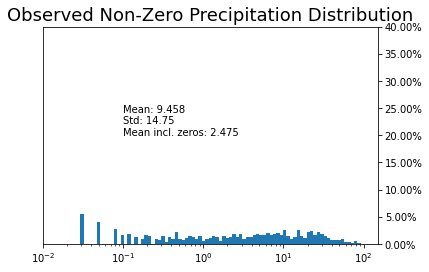

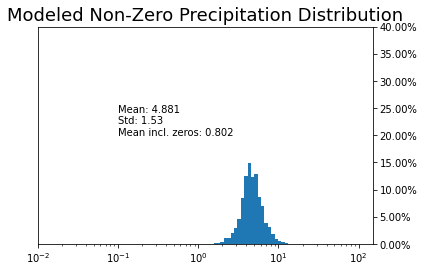

In [109]:
def plotDists(final_preds):
    """Plotting the true and modeled distributions on a log scale"""
    for data, title in zip([Y_test.pr**4, final_preds], ['Observed', 'Modeled']):
        prednon0=data[data > 0.00] #filtering to get only non-zero precip values
        length = prednon0.shape[0] #number of pts
        pmean = round(float(prednon0.mean()),3) #mean
        pstd = round(float(prednon0.std()),3) #standard deviation
        amean = round(float(data.mean()),3) #mean including no precip days

        #getting it on a log scale
        ax = plt.subplot()
        ax.set_xscale("log", nonposx='clip')
        logbins = np.geomspace(0.01,150, 100) #args are x-min, x-max, number of bins

        #plot details
        plt.hist(prednon0,bins=logbins, weights=np.ones(length) / length) #plot percentages
        plt.title(title + ' Non-Zero Precipitation Distribution',fontsize=18) #title
        plt.xlim(xmin=0.01, xmax = 150)
        plt.ylim(ymin=0, ymax = 0.40)

        #add % to axis labels
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
        ax.yaxis.tick_right()

        #show mean and std
        plt.text(0.1,0.2, "Mean: " + str(pmean) + "\nStd: " + str(pstd) + '\nMean incl. zeros: ' + str(amean))
        plt.show()
        
plotDists(final_preds)

## Adding a normal distribution element

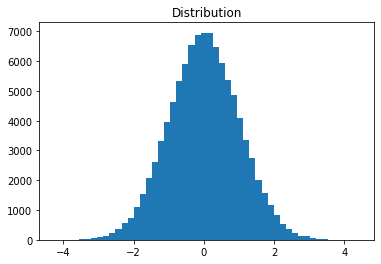

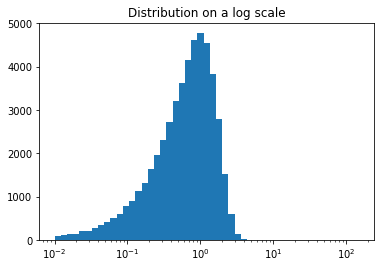

In [6]:
mu, sigma = 0, 1 #mean and standard deviation
data = np.random.normal(mu, sigma, 100000) #gettign 100,000 random points from this distribution

def makePlots(data):
    """Plotting a distibution on a normal scale and on a log scale."""
    
    #plotting a normal distribution
    plt.hist(data, bins = 50)
    plt.title('Distribution')
    plt.show()

    #plotting the same distribution on a log scale
    ax = plt.subplot()
    ax.set_xscale("log", nonposx='clip')
    logbins = np.geomspace(0.01,150, 50)
    plt.hist(data, bins=logbins)
    plt.title('Distribution on a log scale')
    plt.show()
    
makePlots(data)

## Gamma Distributions 

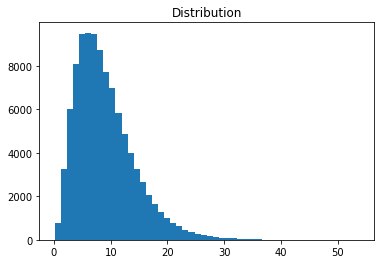

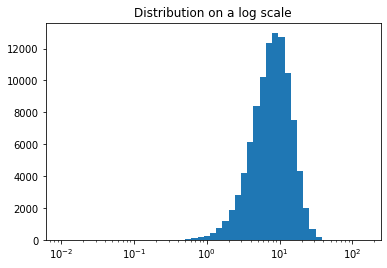

In [9]:
k = 3 #shape
theta = 3 #scale

makePlots(np.random.gamma(k,theta,100000))

## Adding a stochastic element to the predictions

You can change the distributions to see what works the best

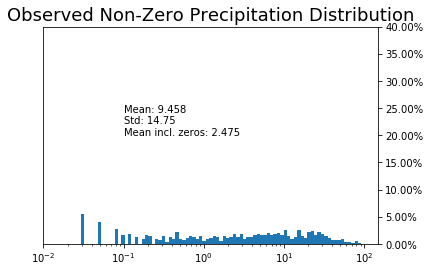

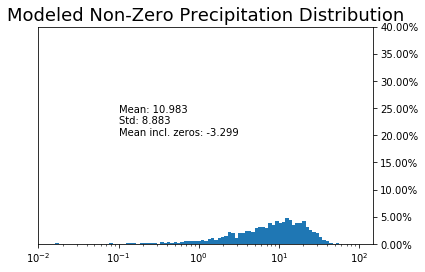

In [24]:
#Normal 
mu, sigma =-5, 15

#Gamma
k, theta = 2,5

np.random.seed(42)

#toggle these two lines to do a normal or gamma distribution
stochast = np.random.normal(mu, sigma, final_preds.shape[0])
#stochast = np.random.gamma(k,theta,final_preds.shape[0])

corrected_preds = final_preds + stochast

plotDists(corrected_preds)

### Write the final predictions to disk

In [29]:
#save location
location = '/glade/work/kwheelan/datasets'

#just saving as a txt file right now, but I could convert to xarray if needed
#saves just the predicted precip values in order of data
np.savetxt(os.path.join(location, 'oddYrPreds_' + str(lat) + '.' + str(lon) + '.txt'), corrected_preds, delimiter = ',')